In [14]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import util.munge as munge
from util.munge import palette
import util.visualizations as viz

import warnings
warnings.filterwarnings("ignore")

plt.style.use('fivethirtyeight')

In [2]:
def import_cdc_data(filename:str, column_headers=None):
    df = pd.read_csv(filename, parse_dates=[0])
    df.drop(["Footnote", "Start week", "End Week"], axis=1, inplace=True)
    if column_headers is not None:
        df.columns = column_headers
    df = df.rename(columns={"date_as_of":"date"})
    df['race_and_ethnicity'] = df['race_and_ethnicity'].map(munge.cdc_races)
    
    # combine NY and NYC
    df.loc[df["state"] == "New York City", "state"] = "New York"
    df = df.groupby(["date", "state", "age_group", "race_and_ethnicity"]).sum().reset_index()
    
    return df.loc[df["state"] != 'United States']

# import cdc data
cdc3 = import_cdc_data("data/cdc_deaths_by_race_age_20200603.csv")
cdc3_no_age = cdc3.groupby(["state", "race_and_ethnicity"])["covid_19_deaths"] \
    .sum().reset_index(name="covid_19_deaths")
cdc10 = import_cdc_data("data/cdc_deaths_by_race_age_20200610.csv", cdc3.columns) 
cdc10_no_age = cdc10.groupby(["state", "race_and_ethnicity"])["covid_19_deaths"] \
    .sum().reset_index(name="covid_19_deaths")


cdc_race_eth_cols = cdc10['race_and_ethnicity'].unique()

cdc10.head()

,date,state,age_group,race_and_ethnicity,covid_19_deaths,total_deaths,pneumonia_deaths,pneumonia_and_covid_19_deaths,influenza_deaths,pneumonia_influenza_or_covid_19_deaths
0,2020-06-10,Alabama,1-4 years,AIAN,0.0,0.0,0.0,0.0,0.0,0.0
1,2020-06-10,Alabama,1-4 years,NHPI,0.0,0.0,0.0,0.0,0.0,0.0
2,2020-06-10,Alabama,1-4 years,asian,0.0,0.0,0.0,0.0,0.0,0.0
3,2020-06-10,Alabama,1-4 years,black,0.0,11.0,0.0,0.0,0.0,0.0
4,2020-06-10,Alabama,1-4 years,latinx,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
def import_our_data(date=None):
    df = pd.read_csv("data/Race Data Entry - Tracker Commits.csv", parse_dates=["date"])
    df = df.drop([col for col in df.columns if "Unnamed" in col], axis=1) \
        .drop([col for col in df.columns if "positives" in col], axis=1) \
        .drop([col for col in df.columns if "negatives" in col], axis=1) \
        .drop(["last_check","update_time"], axis=1)
    df["state"] = df["state"].map(munge.state_full_names)
    if date:
        df = df.loc[df["date"] == date]
    return df

ours = import_our_data()
ours3 = import_our_data("2020-06-03")
ours10 = import_our_data("2020-06-10")

ours_race_eth_cols = [col for col in ours10.columns 
                        if ("deaths" in col) and not ("percent" in col) and not ("unknown" in col) 
                        and (col != "total_deaths")]

ours10_long = ours10.set_index("state")
ours10_long = ours10_long[ours_race_eth_cols].stack().reset_index()
ours10_long.columns = ["state", "race_and_ethnicity", "covid_19_deaths"]
ours10_long["race_and_ethnicity"] = ours10_long["race_and_ethnicity"].map(munge.crdt_to_cdc_races)

ours10_long.head()


,state,race_and_ethnicity,covid_19_deaths
0,Alaska,white,6.0
1,Alaska,black,0.0
2,Alaska,asian,2.0
3,Alaska,AIAN,2.0
4,Alaska,NHPI,1.0


In [4]:
ours10.columns

Index(['date', 'state', 'total_deaths', 'deaths_white', 'deaths_black',
       'deaths_latinx', 'deaths_asian', 'deaths_aian', 'deaths_nhpi',
       'deaths_multiracial', 'deaths_other', 'deaths_race_unknown',
       'deaths_percent_race_unknown', 'deaths_hispanic', 'deaths_nonhispanic',
       'deaths_ethnicity_unknown', 'deaths_percent_ethnicity_unknown'],
      dtype='object')

In [5]:
cdc10["race_and_ethnicity"].unique()

array(['AIAN', 'NHPI', 'asian', 'black', 'latinx', 'multiracial',
       'unknown', 'white'], dtype=object)

## Are there states where only one of us (CDC or CRDT) have data?

In [6]:
ours10_completeness = ours10[["state"] + ours_race_eth_cols].sort_values("state")
ours10_completeness["total_data_points"] = ours10_completeness[ours_race_eth_cols].notnull().sum(axis=1)
ours10_completeness.set_index("state", inplace=True)
ours10_completeness["no_data"] = [row["total_data_points"] == 0 for i, row in ours10_completeness.iterrows()]

In [7]:
cdc10_completeness = cdc10_no_age \
    .pivot(index="state", columns="race_and_ethnicity", values="covid_19_deaths")
cdc10_completeness["total_data_points"] = cdc10_completeness[cdc_race_eth_cols].notnull().sum(axis=1)
cdc10_completeness["total_data_points_zero"] = cdc10_completeness.replace(0, np.nan).isna().sum(axis=1)

cdc10_completeness["no_data"] = [row["total_data_points_zero"] == 8 for i, row in cdc10_completeness.iterrows()]

Ok, a few things here. So the CDC reports 0 even when they DON'T have data, evidenced by several states having 0 covid deaths recorded for every race. So I'm looking to see which states we don't have data for and comparing that to which states the CDC recorded 0 deaths across all races.

In [8]:
data_completeness = cdc10_completeness[["no_data"]].merge(
    ours10_completeness[["no_data"]],
    how="outer",
    left_index=True,
    right_index=True,
    suffixes=["_cdc", "_crdt"]
).fillna(True)

In [9]:
to_print_has_data = data_completeness.loc[(data_completeness["no_data_cdc"] == data_completeness["no_data_crdt"]) & 
                     (data_completeness["no_data_cdc"] == False)]
to_print_no_data = data_completeness.loc[(data_completeness["no_data_cdc"] == data_completeness["no_data_crdt"]) & 
                     (data_completeness["no_data_cdc"] == True)]

print(f"HAS DATA States (both CDC + CRDT): {to_print_has_data.shape[0]}")
print(f"NO DATA States (both CDC + CRDT): {to_print_no_data.shape[0]} {to_print_no_data.index.values}")
   

HAS DATA States (both CDC + CRDT): 42
NO DATA States (both CDC + CRDT): 6 ['American Samoa' 'Guam' 'Hawaii' 'Montana' 'Northern Mariana Islands'
 'Virgin Islands']


In [10]:
data_completeness.loc[data_completeness["no_data_cdc"] != data_completeness["no_data_crdt"]] \
    .sort_values("no_data_cdc")

,no_data_cdc,no_data_crdt
state,,
Nebraska,False,True
New Mexico,False,True
North Dakota,False,True
Puerto Rico,False,True
South Dakota,False,True
Utah,False,True
Alaska,True,False
Wyoming,True,False


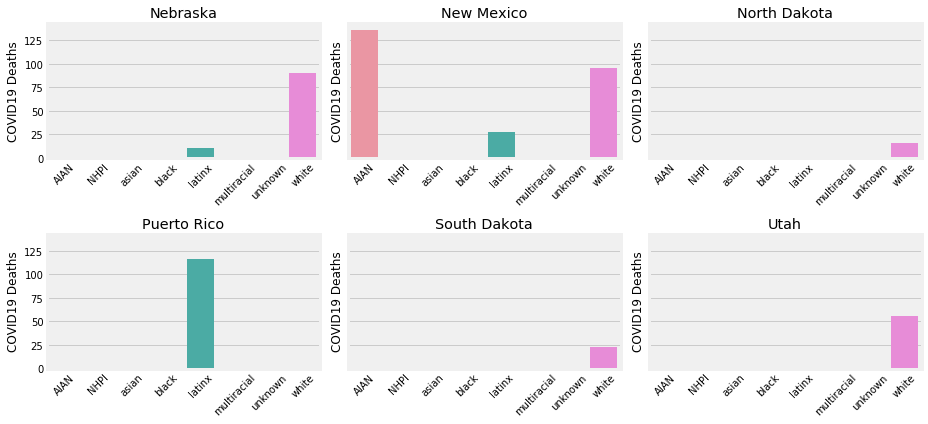

In [11]:
data_completeness_only_cdc = data_completeness.loc[
    (data_completeness["no_data_cdc"] != data_completeness["no_data_crdt"]) &
    (data_completeness["no_data_cdc"] == False)] 

# plot deaths-by-race for states
to_plot = cdc10_no_age.copy(deep=True)

fig, axs = plt.subplots(2, 3, figsize=(13,6), sharey=True, tight_layout=True)
plt_axis = [0, 0]
count = 0

for state in data_completeness_only_cdc.index.values:
        
    current_ax = axs[plt_axis[0], plt_axis[1]]
    
    if state != "New York City":
        to_plot_state = to_plot.loc[to_plot["state"] == state]
        sns.barplot(
            x="race_and_ethnicity", y="covid_19_deaths", 
            data=to_plot_state, ax=current_ax)
        
        current_ax.set(
            xlabel="",
            ylabel="COVID19 Deaths",
            title=state)
        current_ax.set_xticklabels(current_ax.get_xticklabels(), rotation=45)
    
        # get position of next plot
        count = count + 1
        if count == 3:
            plt_axis[0] = 1
            plt_axis[1] = 0
        else:
            plt_axis[1] = plt_axis[1] + 1

plt.show()
    


## How similar is our data to the CDC for the 42 states where we both have data?

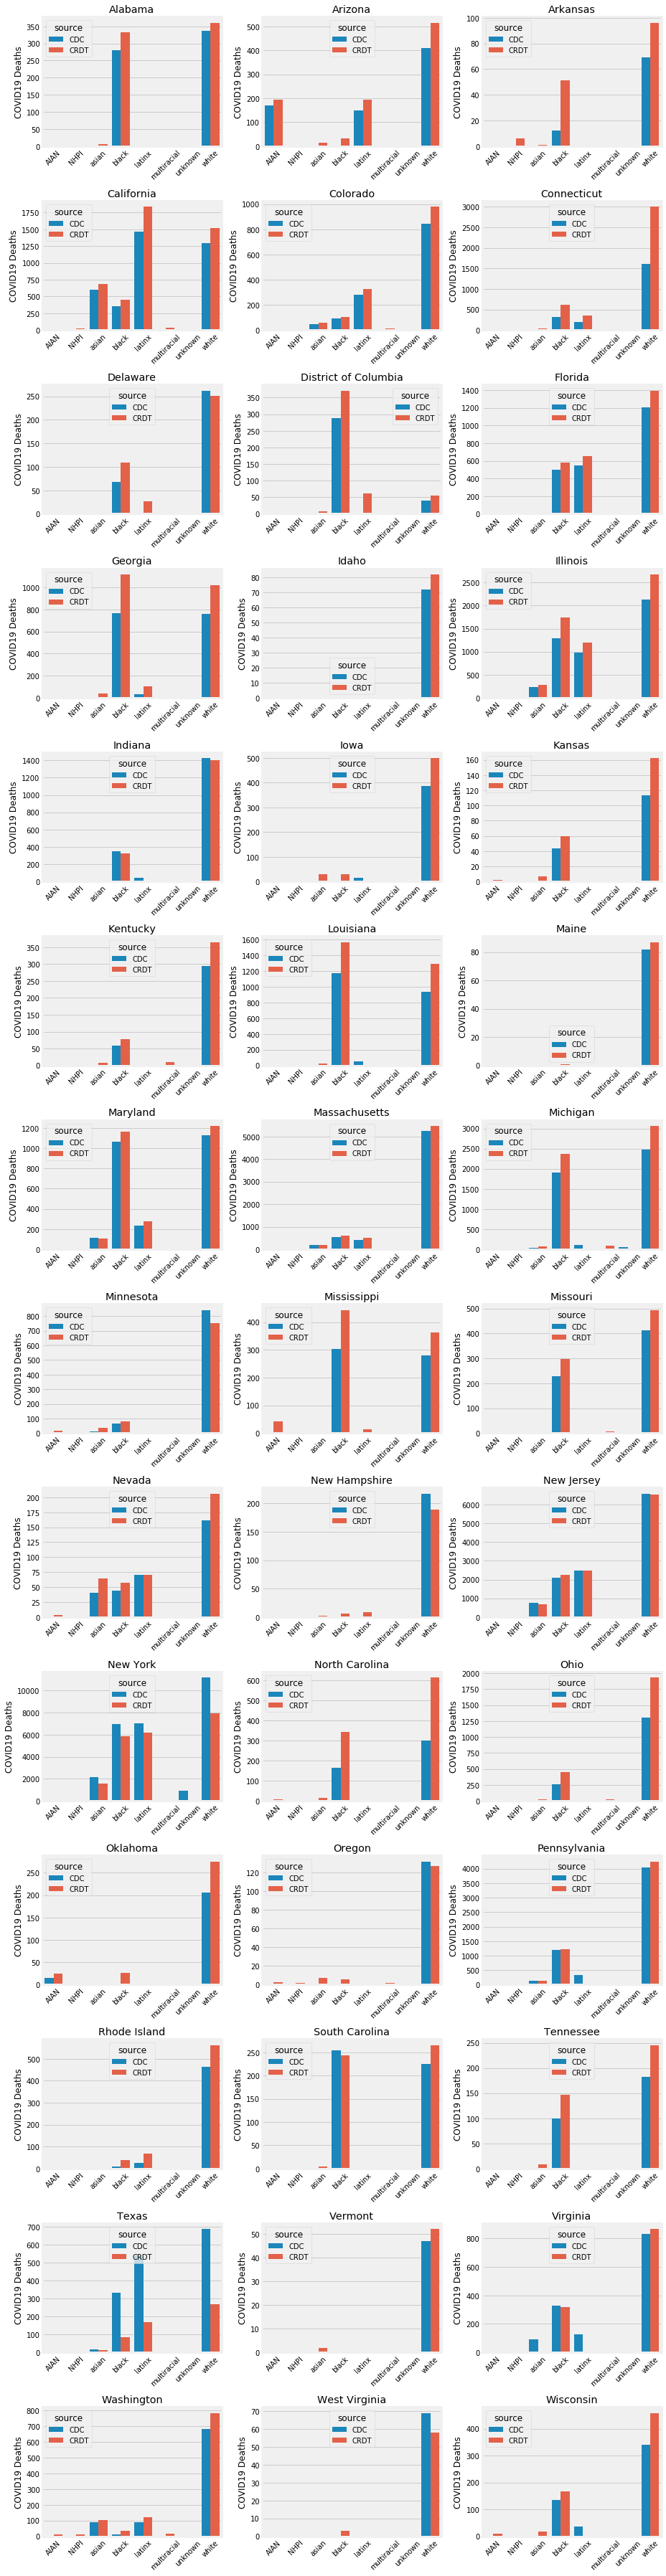

In [12]:
data_states = list(data_completeness.loc[(data_completeness["no_data_cdc"] == data_completeness["no_data_crdt"]) & 
                     (data_completeness["no_data_cdc"] == False)].index)

fig, axs = plt.subplots(14, 3, figsize=(13,50), tight_layout=True)

for i, state in zip(range(len(data_states)), data_states):
    
    current_ax = axs[int(np.floor(i / 3)), int(i % 3)]
    
    to_plot_cdc = cdc10_no_age.loc[cdc10_no_age["state"] == state]
    to_plot_cdc["source"] = "CDC"
    to_plot_ours = ours10_long.loc[
        (ours10_long["state"] == state) & 
        ~(ours10_long["race_and_ethnicity"].isin(["hispanic", "nonhispanic", "other"]))]
    to_plot_ours["source"] = "CRDT"
    to_plot = pd.concat([to_plot_cdc, to_plot_ours], axis=0)
    
    sns.barplot(x="race_and_ethnicity", y="covid_19_deaths", hue="source", 
                data=to_plot,
                ax=current_ax
               )
    current_ax.set_xticklabels(current_ax.get_xticklabels(), rotation=45)
    current_ax.set(
        xlabel="",
        ylabel="COVID19 Deaths",
        title=state)
    
plt.show()
    

Let's look at this as % different

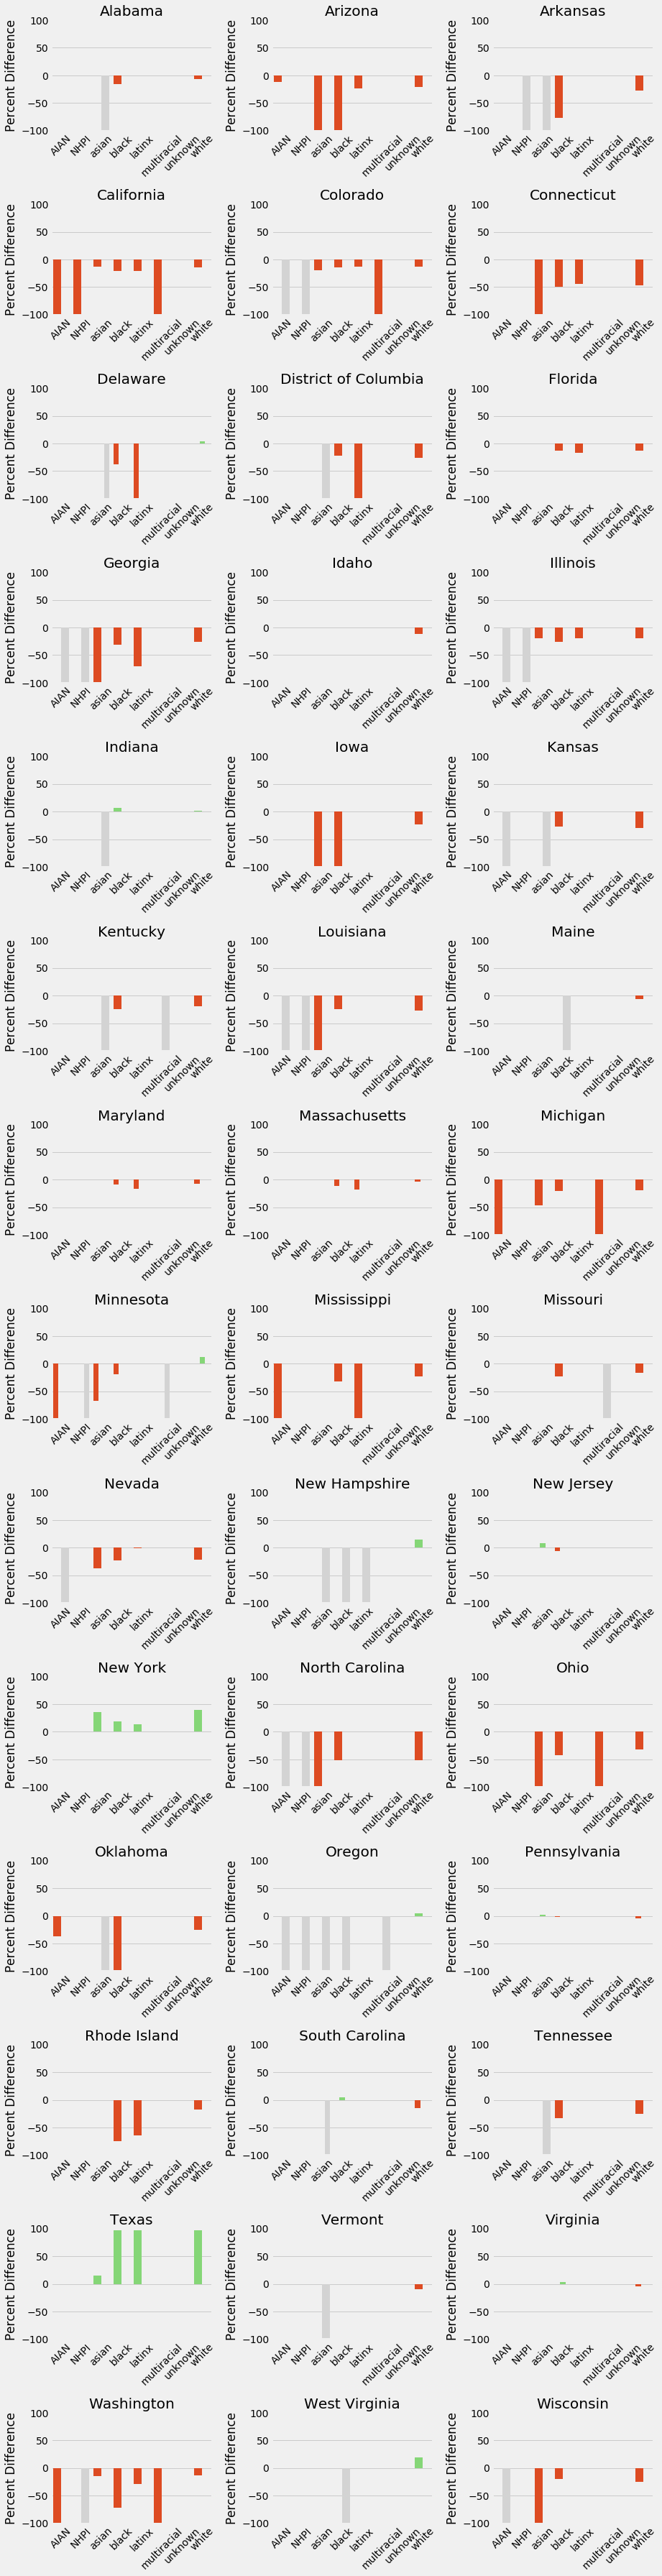

In [15]:
fig, axs = plt.subplots(14, 3, figsize=(13,50), tight_layout=True)

for i, state in zip(range(len(data_states)), data_states):
    
    current_ax = axs[int(np.floor(i / 3)), int(i % 3)]
    
    to_plot_cdc = cdc10_no_age.loc[cdc10_no_age["state"] == state]
    to_plot_ours = ours10_long.loc[
        (ours10_long["state"] == state) & 
        ~(ours10_long["race_and_ethnicity"].isin(["hispanic", "nonhispanic", "other"]))]
    
    to_plot = to_plot_cdc.merge(
        to_plot_ours, 
        how='outer', 
        on=["state", "race_and_ethnicity"], 
        suffixes=["_cdc", "_crdt"]).fillna(0)
    to_plot["percent_diff_from_crdt"] = 100*((
        to_plot["covid_19_deaths_cdc"] - to_plot["covid_19_deaths_crdt"]) / to_plot["covid_19_deaths_crdt"])
    
    to_plot["direction"] = [str(i) for i in to_plot["percent_diff_from_crdt"] / abs(to_plot["percent_diff_from_crdt"])]
    
    # let's suppress any row where CRDT doesn't have at least 10 cases
    to_plot.loc[to_plot["covid_19_deaths_crdt"] <= 10, 'direction'] = str(np.nan)

    
    
    sns.barplot(x="race_and_ethnicity", y="percent_diff_from_crdt", hue="direction",
                data=to_plot,
                ax=current_ax,
                palette={"-1.0":palette["red"],  "1.0": palette["green"], "nan":palette["lightgrey"]}
               )
    current_ax.set_xticklabels(current_ax.get_xticklabels(), rotation=45)
    current_ax.set(
        ylim=(-100, 100),
        xlabel="",
        ylabel="Percent Difference",
        title=state)
    current_ax.get_legend().remove()
       
plt.show()
    

That's a lot of pretty sizable differences actually. And other than like, Texas, the CDC is under reporting relative to our numbers. I want to get a general sense for how wrong these numbers might be. Can we use the to disset age in a "directional" sort of way?

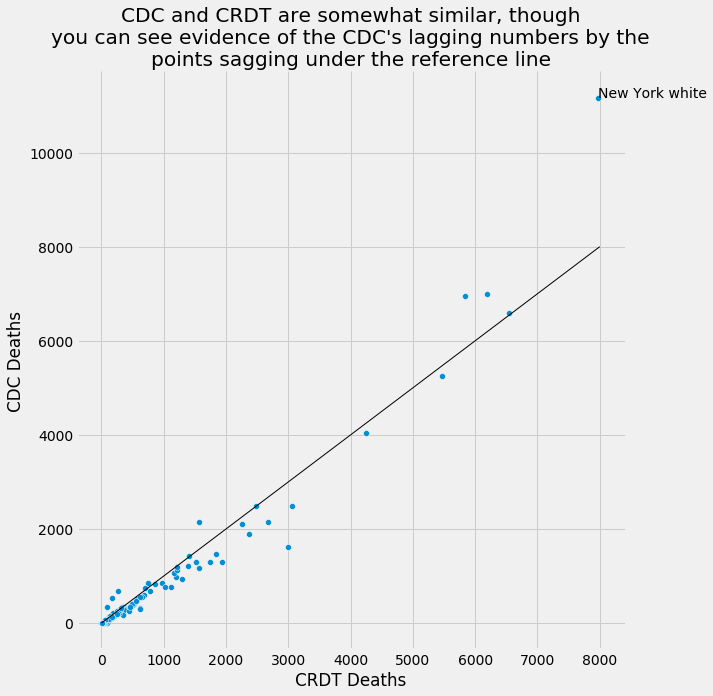

In [76]:
cdc10_no_age
ours10_long_no_eth = ours10_long.loc[
    ~(ours10_long["race_and_ethnicity"].isin(["hispanic", "nonhispanic", "other"]))]
to_plot = cdc10_no_age.merge(ours10_long_no_eth, how="outer", on=["state","race_and_ethnicity"], 
                  suffixes=["_cdc", "_crdt"])

to_plot["error"] = abs(to_plot["covid_19_deaths_cdc"] - to_plot["covid_19_deaths_crdt"])/to_plot["covid_19_deaths_crdt"]

to_plot["label"] = ""
to_plot.loc[
    (to_plot["state"] == "New York") & 
    (to_plot["race_and_ethnicity"] == "white"), "label"] = to_plot["state"] + " " + to_plot["race_and_ethnicity"]

X_plot = np.linspace(0, 8000, 100)

g = sns.FacetGrid(to_plot, size = 9)
g = g.map(plt.scatter, "covid_19_deaths_crdt", "covid_19_deaths_cdc", edgecolor="w")
plt.plot(X_plot, X_plot, color='black', linewidth=1)

def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x'], point['y'], str(point['val']))

label_point( to_plot.covid_19_deaths_crdt, to_plot.covid_19_deaths_cdc,
            to_plot.label, plt.gca())  

g.set(
    xlabel="CRDT Deaths",
    ylabel="CDC Deaths",
    title="CDC and CRDT are somewhat similar, though\nyou can see evidence of the CDC's lagging numbers by the\npoints sagging under the reference line"
)
plt.show()


## Let's zoom in on the cases below 2000

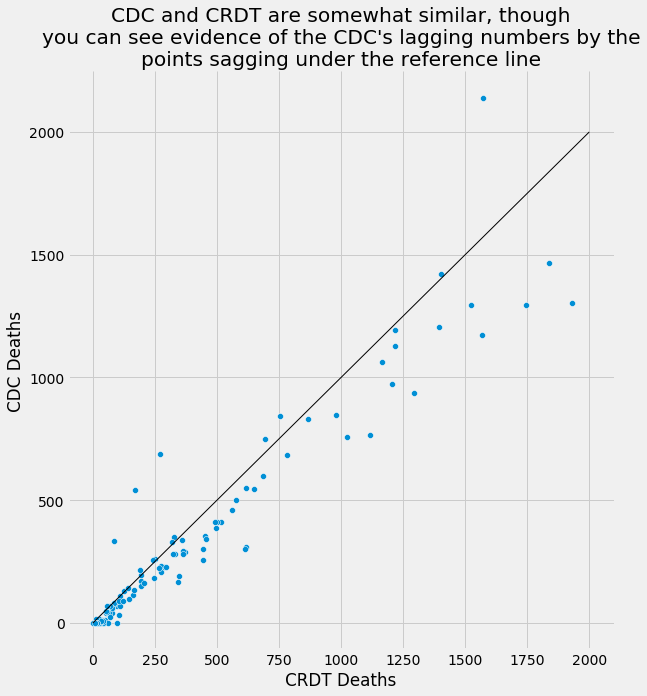

In [75]:
to_plot = to_plot.loc[to_plot["covid_19_deaths_crdt"] < 2000]
X_plot = np.linspace(0, 2000, 100)

g = sns.FacetGrid(to_plot, size = 9)
g = g.map(plt.scatter, "covid_19_deaths_crdt", "covid_19_deaths_cdc", edgecolor="w")
plt.plot(X_plot, X_plot, color='black', linewidth=1)

# def label_point(x, y, val, ax):
#     a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
#     for i, point in a.iterrows():
#         ax.text(point['x'], point['y'], str(point['val']))

# label_point( to_plot.covid_19_deaths_crdt, to_plot.covid_19_deaths_cdc,
#             to_plot.label, plt.gca())  

g.set(
    xlabel="CRDT Deaths",
    ylabel="CDC Deaths",
    title="CDC and CRDT are somewhat similar, though\nyou can see evidence of the CDC's lagging numbers by the\npoints sagging under the reference line"
)
plt.show()


## Are states sharing data uniformly in the CDC dataset?

In [12]:
ours10_combined = ours10.loc[ours10["deaths_latinx"].notnull()]
ours10_separate = ours10.loc[ours10["deaths_latinx"].isnull() & ours10["deaths_white"].notnull()]
ours10_no_data = ours10.loc[ours10["deaths_latinx"].isnull() & ours10["deaths_white"].isnull()]


In [13]:
print(f"{ours10_combined.shape[0]} CRDT States reporting race only:\n{ours10_combined.state.values}")
print(f"\n{ours10_separate.shape[0]} CRDT States reporting race and ethnicity:\n{ours10_separate.state.values}")
print(f"\n{ours10_no_data.shape[0]} CRDT States not reporting race and ethnicity:\n{ours10_no_data.state.values}")

20 CRDT States reporting race only:
['Arizona' 'California' 'Colorado' 'Connecticut' 'District of Columbia'
 'Delaware' 'Florida' 'Georgia' 'Illinois' 'Massachusetts' 'Maryland'
 'Mississippi' 'New Hampshire' 'New Jersey' 'Nevada' 'New York'
 'Rhode Island' 'Texas' 'Washington' 'Wyoming']

24 CRDT States reporting race and ethnicity:
['Alaska' 'Alabama' 'Arkansas' 'Iowa' 'Idaho' 'Indiana' 'Kansas'
 'Kentucky' 'Louisiana' 'Maine' 'Michigan' 'Minnesota' 'Missouri'
 'North Carolina' 'Ohio' 'Oklahoma' 'Oregon' 'Pennsylvania'
 'South Carolina' 'Tennessee' 'Virginia' 'Vermont' 'Wisconsin'
 'West Virginia']

12 CRDT States not reporting race and ethnicity:
['American Samoa' 'Guam' 'Hawaii' 'Northern Mariana Islands' 'Montana'
 'North Dakota' 'Nebraska' 'New Mexico' 'Puerto Rico' 'South Dakota'
 'Utah' 'Virgin Islands']


## Does the CRDT Data Align with the CDC's Data?

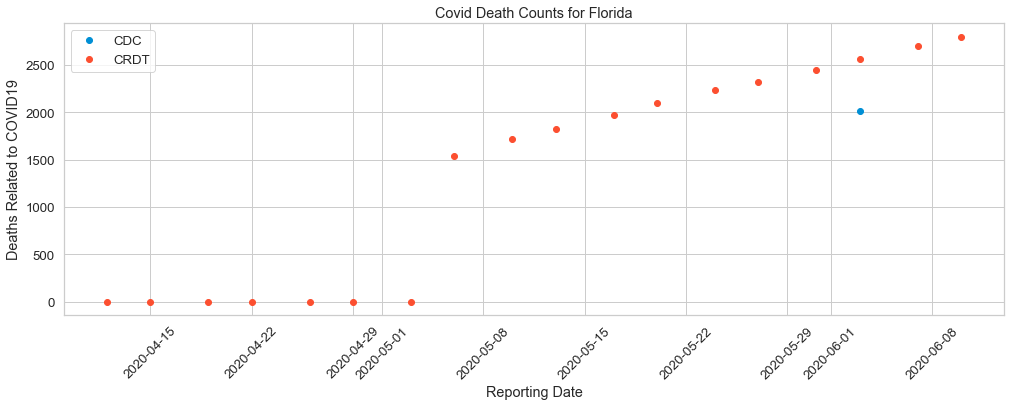

In [37]:
state = "Florida"

cdc_to_plot = cdc3.groupby(["state", "date"])["covid_19_deaths"].sum().reset_index()
cdc_to_plot = cdc_to_plot.loc[cdc_to_plot["state"] == state]
cdc_to_plot["date"] = pd.to_datetime(cdc_to_plot["date"]).dt.date
ours_to_plot = ours.groupby(["state", "date"])["total_deaths"].sum().reset_index()
ours_to_plot = ours_to_plot.loc[ours_to_plot["state"] == state]

fig, ax = plt.subplots(figsize=(15,5))
ax.plot_date(cdc_to_plot["date"], cdc_to_plot["covid_19_deaths"], label="CDC")
ax.plot_date(ours_to_plot["date"], ours_to_plot["total_deaths"], label="CRDT")
plt.xticks(rotation=45)
plt.xlabel("Reporting Date")
plt.ylabel("Deaths Related to COVID19")
plt.title(f"Covid Death Counts for {state}")
plt.legend()
plt.show()

## Are there any outliers in race data reporting at the state level?

This data is pretty different. We're comparing apples to oranges really. So let's do 2 things:

1. If we aggregate the totals per state for each reported metric, how similar are we?
2. On a state-by-state basis, let's come up with a low-ball high-ball range for what the reported race numbers could be. We won't really know if we are right on, so can we tell if the numbers are completely off?

### Total Deaths

In [38]:
to_plot_cdc = cdc10.replace("New York City", "New York") \
    .groupby(["date","state"])["covid_19_deaths"].sum() \
    .reset_index(name="cdc_total_deaths")[["state", "cdc_total_deaths"]]

to_plot_ours = ours10[["state", "total_deaths"]]
to_plot_ours.columns = ["state", "crdt_total_deaths"]

to_plot = to_plot_cdc.merge(to_plot_ours, how="outer", on="state")

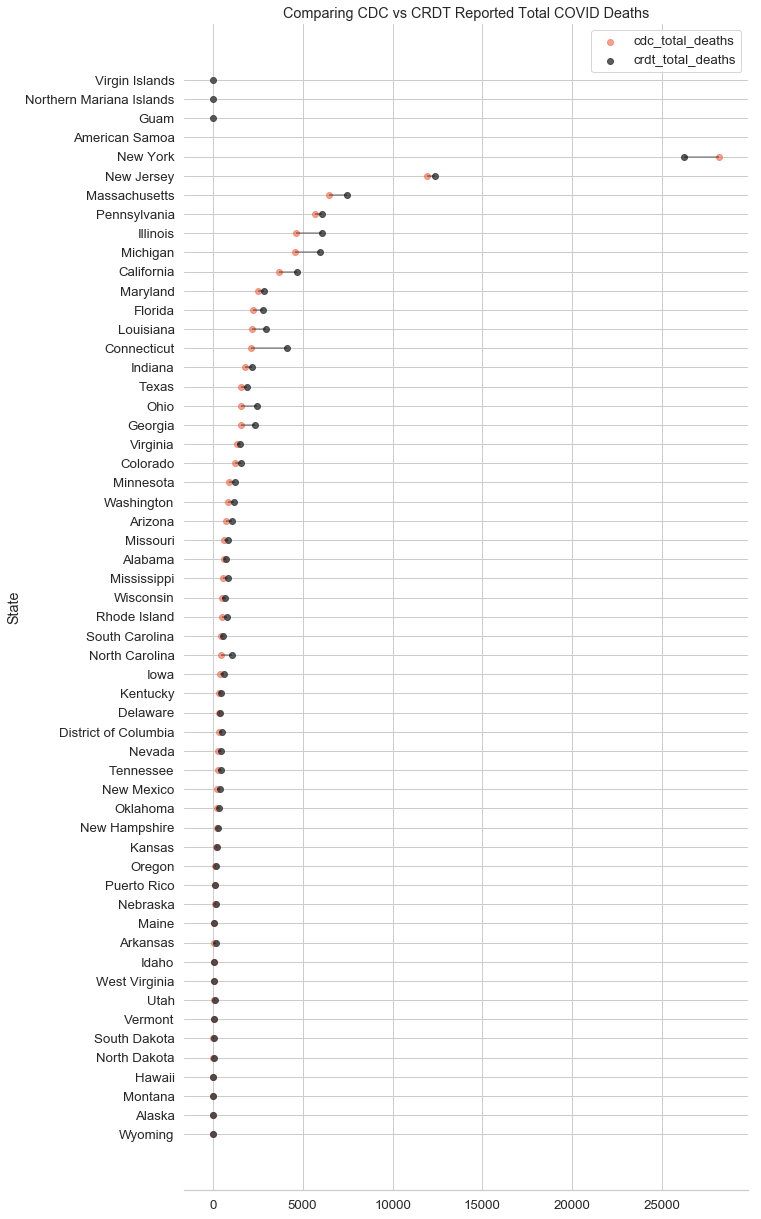

In [39]:
viz.state_level_metric_diff(to_plot, "cdc_total_deaths", "crdt_total_deaths", log=False,
                            plot_title="Comparing CDC vs CRDT Reported Total COVID Deaths")

### Deaths by Race

In [51]:
to_plot_cdc = cdc10.where(cdc10["race_and_ethnicity"] == "Non-Hispanic Black") \
    .replace("New York City", "New York") \
    .groupby(["date","state"])["covid_19_deaths"].sum() \
    .reset_index(name="cdc_deaths_black")[["state", "cdc_deaths_black"]]

to_plot_ours = ours10[["state", "deaths_black"]]
to_plot_ours.columns = ["state", "crdt_deaths_black"]

to_plot = to_plot_cdc.merge(to_plot_ours, how="outer", on="state")
to_plot = to_plot.loc[~to_plot["state"].isin(["Virgin Islands", "Northern Mariana Islands", "Guam", "American Samoa"])]

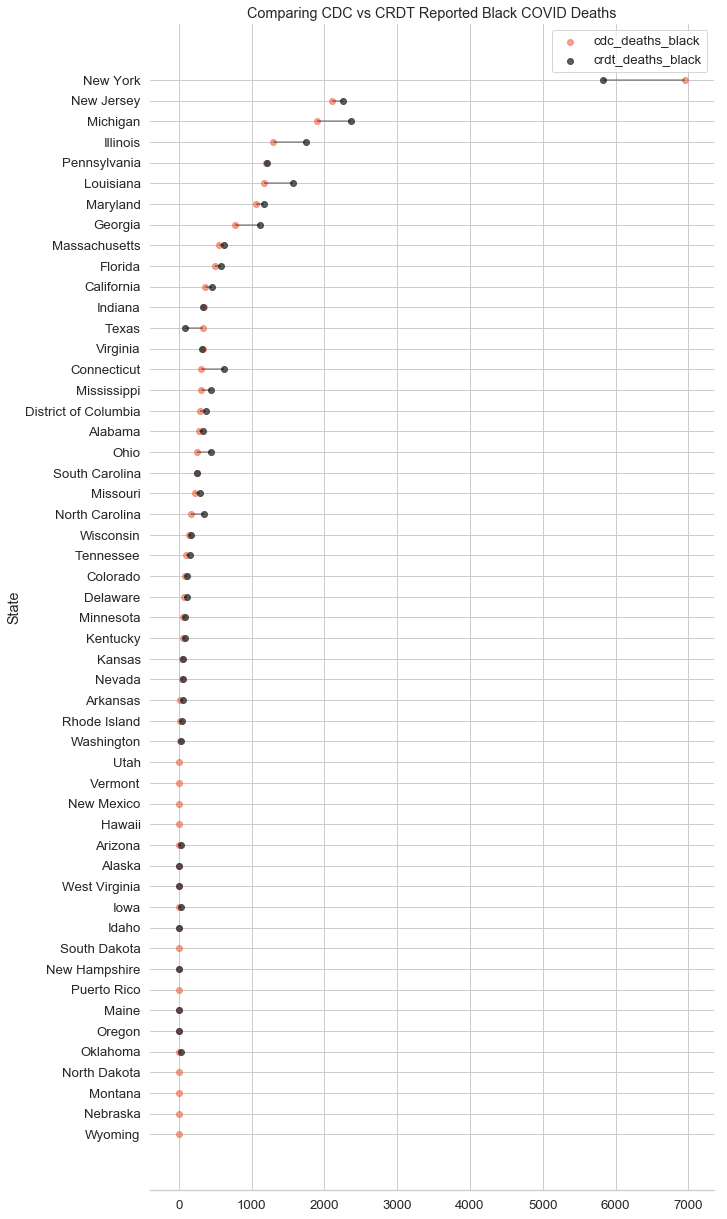

In [52]:
viz.state_level_metric_diff(to_plot, "cdc_deaths_black", "crdt_deaths_black", log=False,
                            plot_title="Comparing CDC vs CRDT Reported Black COVID Deaths")

In [50]:
to_plot_ours.loc[to_plot_ours["state"] == "South Dakota"]

,state,crdt_deaths_black
45,South Dakota,NaN


In [58]:
cdc10.loc[cdc10["state"] == "Utah"]

,date_as_of,state,age_group,race_and_ethnicity,covid_19_deaths,total_deaths,pneumonia_deaths,pneumonia_and_covid_19_deaths,influenza_deaths,pneumonia_influenza_or_covid_19_deaths
4057,2020-06-10,Utah,Under 1 year,Non-Hispanic White,0.0,68.0,NaN,0.0,0.0,NaN
4058,2020-06-10,Utah,1-4 years,Non-Hispanic White,0.0,NaN,0.0,0.0,0.0,0.0
4059,2020-06-10,Utah,5-14 years,Non-Hispanic White,0.0,17.0,0.0,0.0,0.0,0.0
4060,2020-06-10,Utah,15-24 years,Non-Hispanic White,0.0,67.0,NaN,0.0,NaN,NaN
4061,2020-06-10,Utah,25-34 years,Non-Hispanic White,0.0,134.0,NaN,0.0,NaN,NaN
4062,2020-06-10,Utah,35-44 years,Non-Hispanic White,0.0,208.0,NaN,0.0,NaN,NaN
4063,2020-06-10,Utah,45-54 years,Non-Hispanic White,NaN,328.0,14.0,NaN,NaN,21.0
4064,2020-06-10,Utah,55-64 years,Non-Hispanic White,NaN,660.0,28.0,NaN,NaN,39.0
4065,2020-06-10,Utah,65-74 years,Non-Hispanic White,16.0,1107.0,65.0,10.0,NaN,77.0
4066,2020-06-10,Utah,75-84 years,Non-Hispanic White,17.0,1633.0,103.0,NaN,NaN,120.0


In [56]:
to_plot.where(to_plot["state"] == "Utah")

,state,cdc_deaths_black,crdt_deaths_black
0,NaN,NaN,NaN
1,NaN,NaN,NaN
2,NaN,NaN,NaN
3,NaN,NaN,NaN
4,NaN,NaN,NaN
5,NaN,NaN,NaN
6,NaN,NaN,NaN
7,NaN,NaN,NaN
8,NaN,NaN,NaN
9,NaN,NaN,NaN
